In [1]:
import sys
old_stdout = sys.stdout
sys.stdout = open('log.txt', 'w')

In [28]:
from tensorflow import keras
from imutils import paths
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
from keras.applications import ResNet50
from keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Bidirectional, 
    LSTM, 
    GlobalAveragePooling1D, 
    Dense, 
    Input, 
    concatenate
)
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
import mediapipe as mp

In [3]:
train_dir = 'data'
test_dir = 'data'
# 비디오 파일 목록과 태그를 포함하는 리스트를 만드는 함수
def create_data_list(data_dir):
    data_list = []
    # data_dir 안의 각 디렉토리에 대해 반복
    for item in os.listdir(data_dir):
        item_path = os.path.join(data_dir, item)  # 아이템의 전체 경로
        # 해당 경로가 디렉토리인지 확인
        if os.path.isdir(item_path):
            # 디렉토리 내의 모든 파일을 나열
            for file_name in os.listdir(item_path):
                # 파일이 .mp4 파일인지 확인
                if file_name.endswith('.mp4'):
                    # 리스트에 태그와 파일 경로를 추가
                    data_list.append((item, str('data'+'/'+item)+'/'+file_name))
    return data_list

# 함수를 사용해서 리스트를 생성
train_list = create_data_list(train_dir)
test_list = create_data_list(test_dir)
# 리스트에서 데이터프레임을 생성
train_df = pd.DataFrame(data=train_list, columns=['tag', 'video_name'])
test_df = pd.DataFrame(data=test_list, columns=['tag', 'video_name'])
# 필요한 경우 열 순서를 수정
train_df = train_df.loc[:, ['tag', 'video_name']]
test_df = test_df.loc[:, ['tag', 'video_name']]
# 데이터프레임을 CSV 파일로 저장
train_file_path = 'train.csv'
test_file_path = 'test.csv'
train_df.to_csv(train_file_path, encoding='utf-8-sig', index=False)
test_df.to_csv(test_file_path, encoding='utf-8-sig', index=False)

In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print(f"Total video for training: {len(train_df)}")
print(f"Total video for testing: {len(test_df)}")

In [5]:
# GPU 설정
gpus = tf.config.list_physical_devices('GPU')
# GPU가 사용 가능한 경우
if gpus:
    try:
        # 첫 번째 GPU에 대해 메모리 제한 설정
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], 
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)]
        )
    except RuntimeError as e:
        print(e)

In [6]:
IMG_SIZE = 250
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048
SKELETON_FEATURES = 33*4
HAND_FEATURES = 21*3*2

In [7]:
# 라벨링
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
labels = train_df["tag"].values
labels = label_processor(labels[..., None]).numpy()

In [8]:
# 주어진 이미지에서 중앙에 맞춰 정사각형으로 잘나내는 함수
def crop_center_square(frame):
    # 이미지의 높이(y)와 너비(x)를 가져옴
    y, x = frame.shape[0:2]
    # 이미지의 높이와 너비 중 더 작은 값을 선택하여 정사각형의 크기를 결정
    min_dim = min(y, x)
    # 정사각형을 이미지 중앙에 위치시키기 위해 시작점의 x좌표와 y좌표를 계산
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    # 계산된 시작점과 정사각형의 크기를 이용하여 이미지의 중앙 부분을 잘라냅니다.
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [9]:
# 비디오 파일을 로드하고, 각 프레임을 처리하여 배열로 반환하는 함수
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    mp_hands = mp.solutions.hands
    mp_pose = mp.solutions.pose

    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, smooth_landmarks=True)
    hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
    # OpenCV를 사용하여 비디오 파일 열기
    cap = cv2.VideoCapture(path)
    frames = []
    skeletons = []  # 스켈레톤 데이터
    hand_landmarks = []  # 손 데이터

    try:
        while True:
            # 비디오에서 프레임을 하나씩 읽기
            ret, frame = cap.read()
            # 읽을 프레임이 없으면 반복문을 종료
            if not ret:
                break
            # 읽은 프레임에서 중앙의 정사각형 부분을 잘라냄
            frame = crop_center_square(frame)
            # 프레임의 크기를 지정된 크기로 조절
            frame = cv2.resize(frame, resize)            
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Mediapipe를 사용하여 스켈레톤 추출
            hands_results = hands.process(frame_rgb)
            pose_results = pose.process(frame_rgb)
           
            if pose_results.pose_landmarks:
                skeletons.append(pose_results.pose_landmarks.landmark)
                mp.solutions.drawing_utils.draw_landmarks(
                    frame, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)            
                
            if hands_results.multi_hand_landmarks:
                hand_landmarks_data = hands_results.multi_hand_landmarks
                hand_landmarks.append(hand_landmarks_data)
                for hand_lm in hand_landmarks_data:
                    mp.solutions.drawing_utils.draw_landmarks(
                        frame, hand_lm, mp_hands.HAND_CONNECTIONS)
            
            cv2.imshow('Video Frame', frame)
            cv2.waitKey(30)
            # OpenCV는 BGR 색상 순서를 사용하므로, 이를 RGB 순서로 변경
            frame = frame[:, :, [2, 1, 0]]
            # 처리된 프레임을 프레임 리스트에 추가
            frames.append(frame)
            # max_frames가 지정된 경우, 지정된 수의 프레임만큼만 처리
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 파일을 닫기
        cv2.destroyAllWindows()
        cap.release()
        pose.close
        hands.close
    return np.array(frames), skeletons, hand_landmarks

In [10]:
# 특징추출
def build_feature_extractor():
    # 이미지 특징 추출을 위한 InceptionV3 모델
    base_model = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input
    image_input = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed_image = preprocess_input(image_input)
    image_features = base_model(preprocessed_image)

    # Mediapipe 데이터를 위한 입력 레이어 및 처리 레이어
    # 예시로, Mediapipe 데이터의 차원을 상정하여 입력 레이어를 정의
    mediapipe_input = keras.Input((258,))
    mediapipe_features = keras.layers.Dense(258, activation="relu")(mediapipe_input)

    # 이미지 특징과 Mediapipe 데이터의 결합
    combined_features = keras.layers.concatenate([image_features, mediapipe_features])

    # 최종 모델
    outputs = keras.layers.Dense(15, activation="softmax")(combined_features)
    return keras.Model(inputs=[image_input, mediapipe_input], outputs=outputs, name="feature_extractor")

In [11]:
# 손 랜드마크를 2개로 제한한 코드
def preprocess_skeleton_data(skeleton):
    # 스켈레톤 데이터가 없는 경우 빈 벡터 반환
    if not skeleton:
        return np.zeros(SKELETON_FEATURES)
    # 스켈레톤 데이터를 1차원 배열로 변환
    skeleton_array = np.array([[lm.x, lm.y, lm.z] for lm in skeleton]).flatten()    
    # 부족한 부분을 0으로 채우기
    skeleton_array = np.pad(skeleton_array, ((0, max(0, SKELETON_FEATURES - len(skeleton_array)))) )    
    return skeleton_array

def preprocess_hand_data(hand_landmarks):
    # 손 랜드마크 데이터가 없는 경우 빈 벡터 반환
    if not hand_landmarks or len(hand_landmarks) < 2:
        return np.zeros(HAND_FEATURES)
    
    # 첫 번째와 두 번째 손에 대한 랜드마크만 처리
    hand_data = []
    for i in range(2):
        hand_lm = hand_landmarks[i]
        lm_array = np.array([[lm.x, lm.y, lm.z] for lm in hand_lm.landmark]).flatten()
        hand_data.extend(lm_array)

    # 부족한 부분을 0으로 채우기
    hand_data = np.pad(hand_data, ((0, max(0, HAND_FEATURES - len(hand_data)))))

    return np.array(hand_data)

def preprocess_image(frame):    
    frame = image.img_to_array(frame[0])  # frame[0]으로 변경
    frame = preprocess_input(frame)  # ResNet50의 전처리 함수를 사용하여 정규화
    return frame

In [12]:
def prepare_all_video(df):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()

    # Mediapipe 데이터를 저장할 배열 초기화
    frame_skeletons = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, SKELETON_FEATURES), dtype="float32")
    frame_hands = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, HAND_FEATURES), dtype="float32")
    
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
    
    # 이미지 데이터 저장할 배열 초기화
    frame_images = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype="float32")
    
    # 특징 추출기 모델 초기화
    feature_extractor = build_feature_extractor()

    for idx, path in enumerate(video_paths):
        frames, skeletons, hands = load_video(path)
        video_length = min(MAX_SEQ_LENGTH, frames.shape[1])

        for i in range(video_length):
            # 이미지 데이터 전처리 및 특징 추출
            image_feature = preprocess_image(frames[i:i+1])
            image_feature = np.expand_dims(image_feature, axis=0)  # 차원 확장
            
            # InceptionV3 모델에 전처리된 이미지 전달
            image_feature = feature_extractor.layers[0](image_feature)            
            
            # Mediapipe 데이터 전처리
            skeleton_feature = preprocess_skeleton_data(skeletons[i])
            hand_feature = preprocess_hand_data(hands[i])
            combined_mediapipe_data = np.concatenate([skeleton_feature, hand_feature])
            
            # 차원 확장
            combined_mediapipe_data = np.expand_dims(combined_mediapipe_data, axis=0)
            
            # 크기 확인
            print("Image Feature shape:", image_feature.shape)
            print("Combined Mediapipe Data shape:", combined_mediapipe_data.shape)
            
            # 데이터 저장
            frame_images[idx, i, :] = image_feature           

            # Mediapipe 데이터의 전처리 및 저장
            frame_skeletons[idx, i, :] = skeleton_feature
            frame_hands[idx, i, :] = hand_feature

            frame_masks[idx, i] = 1
            
            # 모델 예측
            try:
                frame_feature = feature_extractor.predict([image_feature, combined_mediapipe_data], verbose=0)
                print("Prediction shape:", frame_feature.shape)
            except Exception as e:
                print("Error during prediction:", e)

    # 반환 값에 Mediapipe 데이터 포함
    return (frame_features, frame_skeletons, frame_hands, frame_masks), labels

In [13]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # INFO 메시지를 숨긴다.
tf.get_logger().setLevel('ERROR')         # TensorFlow 로그를 ERROR 레벨로 설정한다.

In [14]:
train_data, train_labels = prepare_all_video(train_df)
test_data, test_labels = train_data, train_labels
train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)
sys.stdout = old_stdout

In [32]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()
    
    # 기존 이미지 특징에 대한 입력
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    # Mediapipe 데이터에 대한 추가 입력 레이어
    skeleton_input = keras.Input((MAX_SEQ_LENGTH, SKELETON_FEATURES))
    hand_input = keras.Input((MAX_SEQ_LENGTH, HAND_FEATURES))  
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
    
    # 이미지 특징 처리를 위한 LSTM 레이어
    x = LSTM(64, return_sequences=True)(frame_features_input, mask=mask_input)
    x = LSTM(32, return_sequences=True)(x)
    x = GlobalAveragePooling1D()(x)  # 시퀀스 전체에 걸친 평균을 계산
    
    # Mediapipe 데이터를 처리하는 추가 네트워크 레이어 (예시)
    # 여기서는 간단히 Dense 레이어를 사용했지만, 필요에 따라 다른 구조를 사용할 수 있습니다.
    y_skeleton = GlobalAveragePooling1D()(skeleton_input)
    y_hand = GlobalAveragePooling1D()(hand_input)   

    # 모든 특징을 결합
    combined = concatenate([x, y_skeleton, y_hand])

    # 결합된 특징에 대한 추가 처리
    z = Dense(
        16,
        activation="relu",
        kernel_regularizer=regularizers.l2(0.01)
    )(combined)
    output = Dense(
        len(class_vocab),
        activation="softmax",
        kernel_regularizer=regularizers.l2(0.01)
    )(z)
    
    lstm_model = keras.Model([frame_features_input, skeleton_input, hand_input, mask_input], output)
    lstm_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return lstm_model

Epoch 1/100
1/2 [==============>...............] - ETA: 7s - loss: 2.6138 - accuracy: 0.1406
Epoch 1: val_loss improved from inf to 2.86192, saving model to tmp\video_classifier_lstm.h5
2/2 [==============================] - 9s 2s/step - loss: 2.5480 - accuracy: 0.1562 - val_loss: 2.8619 - val_accuracy: 0.0000e+00
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 2.5082 - accuracy: 0.1250
Epoch 2: val_loss did not improve from 2.86192
2/2 [==============================] - 0s 79ms/step - loss: 2.4930 - accuracy: 0.1354 - val_loss: 2.9151 - val_accuracy: 0.0000e+00
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 2.4556 - accuracy: 0.1562
Epoch 3: val_loss did not improve from 2.86192
2/2 [==============================] - 0s 81ms/step - loss: 2.4617 - accuracy: 0.1458 - val_loss: 2.9637 - val_accuracy: 0.0000e+00
Epoch 4/100
1/2 [==============>...............] - ETA: 0s - loss: 2.4709 - accuracy: 0.1562
Epoch 4: val_loss did not improve from 2.86192


Epoch 31/100
1/2 [==============>...............] - ETA: 0s - loss: 2.2166 - accuracy: 0.1719
Epoch 31: val_loss did not improve from 2.86192
2/2 [==============================] - 0s 87ms/step - loss: 2.2115 - accuracy: 0.1667 - val_loss: 2.9847 - val_accuracy: 0.0000e+00
Epoch 32/100
1/2 [==============>...............] - ETA: 0s - loss: 2.2194 - accuracy: 0.1406
Epoch 32: val_loss did not improve from 2.86192
2/2 [==============================] - 0s 88ms/step - loss: 2.2058 - accuracy: 0.1667 - val_loss: 2.9922 - val_accuracy: 0.0000e+00
Epoch 33/100
2/2 [==============================] - ETA: 0s - loss: 2.2014 - accuracy: 0.1667
Epoch 33: val_loss did not improve from 2.86192
2/2 [==============================] - 0s 91ms/step - loss: 2.2014 - accuracy: 0.1667 - val_loss: 3.0071 - val_accuracy: 0.0000e+00
Epoch 34/100
2/2 [==============================] - ETA: 0s - loss: 2.1952 - accuracy: 0.1667
Epoch 34: val_loss did not improve from 2.86192
2/2 [==============================]

Epoch 61/100
1/2 [==============>...............] - ETA: 0s - loss: 2.0922 - accuracy: 0.1562
Epoch 61: val_loss did not improve from 2.86192
2/2 [==============================] - 0s 84ms/step - loss: 2.0903 - accuracy: 0.1875 - val_loss: 3.3165 - val_accuracy: 0.0000e+00
Epoch 62/100
1/2 [==============>...............] - ETA: 0s - loss: 2.0883 - accuracy: 0.2031
Epoch 62: val_loss did not improve from 2.86192
2/2 [==============================] - 0s 84ms/step - loss: 2.0869 - accuracy: 0.1667 - val_loss: 3.3343 - val_accuracy: 0.0000e+00
Epoch 63/100
2/2 [==============================] - ETA: 0s - loss: 2.0848 - accuracy: 0.1667
Epoch 63: val_loss did not improve from 2.86192
2/2 [==============================] - 0s 102ms/step - loss: 2.0848 - accuracy: 0.1667 - val_loss: 3.3610 - val_accuracy: 0.0000e+00
Epoch 64/100
1/2 [==============>...............] - ETA: 0s - loss: 2.1020 - accuracy: 0.1406
Epoch 64: val_loss did not improve from 2.86192
2/2 [==============================

Epoch 91/100
1/2 [==============>...............] - ETA: 0s - loss: 1.9858 - accuracy: 0.1875
Epoch 91: val_loss did not improve from 2.86192
2/2 [==============================] - 0s 84ms/step - loss: 2.0202 - accuracy: 0.1875 - val_loss: 4.0258 - val_accuracy: 0.0000e+00
Epoch 92/100
1/2 [==============>...............] - ETA: 0s - loss: 2.0365 - accuracy: 0.2500
Epoch 92: val_loss did not improve from 2.86192
2/2 [==============================] - 0s 84ms/step - loss: 2.0183 - accuracy: 0.2188 - val_loss: 4.0590 - val_accuracy: 0.0000e+00
Epoch 93/100
1/2 [==============>...............] - ETA: 0s - loss: 2.0035 - accuracy: 0.1250
Epoch 93: val_loss did not improve from 2.86192
2/2 [==============================] - 0s 84ms/step - loss: 2.0174 - accuracy: 0.1667 - val_loss: 4.0991 - val_accuracy: 0.0000e+00
Epoch 94/100
1/2 [==============>...............] - ETA: 0s - loss: 2.0247 - accuracy: 0.2031
Epoch 94: val_loss did not improve from 2.86192
2/2 [==============================]

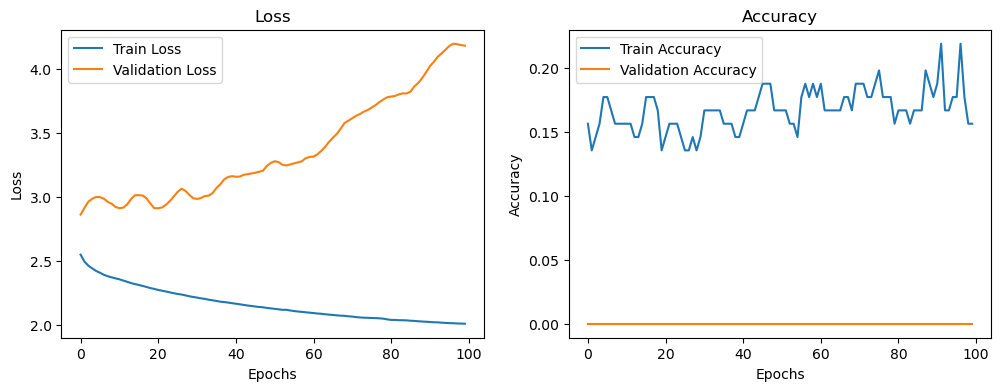

In [35]:
EPOCHS = 100
BATCH_SIZE=64
def run_experiment():
    filepath = "tmp/video_classifier_lstm.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1)

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1], train_data[2], train_data[3]],  # 수정된 입력 데이터
        train_labels,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    
    _, accuracy = seq_model.evaluate(
        [test_data[0], test_data[1], test_data[2], test_data[3]],  # 수정된 입력 데이터
        test_labels
    )
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # 손실 및 정확도 그래프 출력
    plt.figure(figsize=(12, 4))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
    seq_model.save('test_lstm_model.h5')
    
    return history, seq_model

_, sequence_model = run_experiment()

In [36]:
def prepare_single_video(frames, skeletons, hands):
    num_frames = frames.shape[1]
    video_length = min(MAX_SEQ_LENGTH, num_frames)

    frame_mask = np.zeros((1, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros((1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
    frame_skeletons = np.zeros((1, MAX_SEQ_LENGTH, SKELETON_FEATURES), dtype="float32")
    frame_hands = np.zeros((1, MAX_SEQ_LENGTH, HAND_FEATURES), dtype="float32")
    frame_images = np.zeros((1, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype="float32")
    
    feature_extractor = Sequential([
        ResNet50(include_top=False, weights='imagenet', pooling='avg'),  # 예시로 평균 풀링 사용
        Dense(NUM_FEATURES, activation='relu')  # NUM_FEATURES에 맞는 덴스 레이어 추가
    ])
    
    for j in range(video_length):
        # 이미지 데이터 전처리 및 특징 추출
        image_feature = preprocess_image(frames[j:j+1])
        image_feature = np.expand_dims(image_feature, axis=0)
        feature_result = feature_extractor.predict(image_feature)

        # frame_images 대신 feature_result를 사용
        frame_features[0, j] = feature_result

        # Mediapipe 데이터 전처리
        skeleton_feature = preprocess_skeleton_data(skeletons[j])
        hand_feature = preprocess_hand_data(hands[j])

        frame_skeletons[0, j] = skeleton_feature
        frame_hands[0, j] = hand_feature
        frame_mask[0, j] = 1

    return frame_features, frame_skeletons, frame_hands, frame_mask, frame_images

def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()
    frames, skeletons, hands = load_video(path)    
    try:
        num_frames = frames.shape[1]
    except IndexError:
        print("Error: Unable to determine the number of frames. Frames shape:", frames.shape)
        return None
    
    frame_features, frame_skeletons, frame_hands, frame_mask, frame_images = prepare_single_video(frames, skeletons, hands)
    probabilities = sequence_model.predict([frame_features, frame_skeletons, frame_hands, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"{class_vocab[i]} : {probabilities[i] * 100:5.2f}%")
    
    return frame_images

test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")

test_frames = sequence_prediction(test_video)

Test video path: data/NIA_SL_SEN1247/NIA_SL_SEN1247_REAL15_F.mp4
1/1 [==============================] - 2s 2s/step
NIA_SL_SEN1041 : 19.00%
NIA_SL_SEN1090 : 17.62%
NIA_SL_SEN1082 : 15.21%
NIA_SL_SEN1032 : 12.65%
NIA_SL_SEN1103 : 11.45%
NIA_SL_SEN1245 : 10.38%
NIA_SL_SEN1247 :  8.61%
NIA_SL_SEN1173 :  5.07%
